<a href="https://www.kaggle.com/code/jairusmartinez/cycling-energy-regression?scriptVersionId=157027862" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Problem Statement

Many endurance atheletes know what it feels like to hit the wall or to "bonk". Often times, "bonking" occurs when you burn more energy then you consume- leaving you at caloric deficit during a training ride, race, or any endurance activity. Bonking is something many people hate but experience way too often...

To mitigate bonking, you have to be on top of your caloric intake during your activity. For me specifically, when I'm cycling, I want to know how many calories I need to consume to prevent being at such a high deficit. 

Because of this, I wanted to create a cheeky little tool that can predict how many calories I burn for a given activity based on certain aspects of that activity. One approach is to use my personal cycling data with labeled energy outputs and features. I will explore my data and use it to train an ML model that can predict the energy burned in kilojoues. Based on the amount of energy burned, I can convert this number into calories which should then give me a a good estimate on how many calories I should be eating during a particular ride. 

Data was extracted using my own personal Strava Data. The python script that requests the data, transforms it, and exports it into a csv file can be found here: https://github.com/jairus-m/Strava_API/tree/main.

In addition, my full, up-to-date Strava Activity Dashboard can be found here: https://public.tableau.com/app/profile/jairusmartinez/viz/PersonalStravaActivityData/Dashboard1

This dashboard is automatically updated.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import tarfile
import urllib.request

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/strava-activity-data/strava_data.csv


In [2]:
df = pd.read_csv(os.path.join(dirname, filename))
df.head()

,name,distance,moving_time,elapsed_time,total_elevation_gain,sport_type,achievement_count,average_speed,average_watts,weighted_average_watts,kilojoules,average_heartrate,pr_count,average_cadence,date,time,time_bins
0,Zwift - z2 + 1X5min SST,20.31,60.27,60.27,613.52,VirtualRide,0,20.22,137.7,148.0,497.9,142.0,0,NaN,2023-08-29 12:01:05,12,8am-12pm
1,Mexico,0.99,29.18,55.13,164.04,Walk,0,2.03,NaN,NaN,NaN,106.0,0,58.2,2023-08-26 13:39:12,13,12pm-4pm
2,Zwift - 5x1min lactate in Watopia,20.05,60.72,60.72,688.98,VirtualRide,0,19.82,142.8,162.0,520.1,132.1,0,NaN,2023-08-25 09:00:59,9,8am-12pm
3,Ran,3.21,22.72,26.43,59.06,Run,0,8.49,NaN,NaN,NaN,142.1,0,91.7,2023-08-24 18:49:31,18,4pm-8pm
4,Post 1hr zwift,3.59,31.13,32.68,68.90,Run,0,6.93,NaN,NaN,NaN,143.8,0,88.4,2023-08-23 15:02:12,15,12pm-4pm


# Exploratory Data Analysis
1. Initial filter of dataframe
    - filter by sport
    - remove categorical variables
2. Correlation
3. Distribution
4. Outliers
5. Missing Values

## Filter Data

In [3]:
def standard_clean(df):
    '''
    Standard cleaning:
        1. filter by SportType
        2. remove unnecessary columns
        3. drop activties with missing power data

    '''
    X = df.copy()
    X = X.loc[(X['sport_type'] == 'VirtualRide') | (X['sport_type'] == 'Ride')].reset_index(drop=True)
    X = X.drop(['name', 'achievement_count', 'pr_count', 
                'average_cadence', 'time', 'time_bins', 'elapsed_time', 'date'], axis=1)
    X = X.loc[~X['average_watts'].isna()].reset_index(drop=True)
    return X


In [4]:
df = standard_clean(df)

## Correlation

In [5]:
df.select_dtypes(include=np.number).corr()

,distance,moving_time,total_elevation_gain,average_speed,average_watts,weighted_average_watts,kilojoules,average_heartrate
distance,1.000000,0.960151,0.527897,0.302271,0.241908,0.090400,0.914878,0.205960
moving_time,0.960151,1.000000,0.617417,0.096084,0.111638,0.023678,0.904805,0.132384
total_elevation_gain,0.527897,0.617417,1.000000,-0.004636,0.250946,0.200927,0.644570,0.079540
average_speed,0.302271,0.096084,-0.004636,1.000000,0.652543,0.522322,0.257805,0.322875
average_watts,0.241908,0.111638,0.250946,0.652543,1.000000,0.891276,0.433845,0.388955
weighted_average_watts,0.090400,0.023678,0.200927,0.522322,0.891276,1.000000,0.322634,0.388488
kilojoules,0.914878,0.904805,0.644570,0.257805,0.433845,0.322634,1.000000,0.241236
average_heartrate,0.205960,0.132384,0.079540,0.322875,0.388955,0.388488,0.241236,1.000000


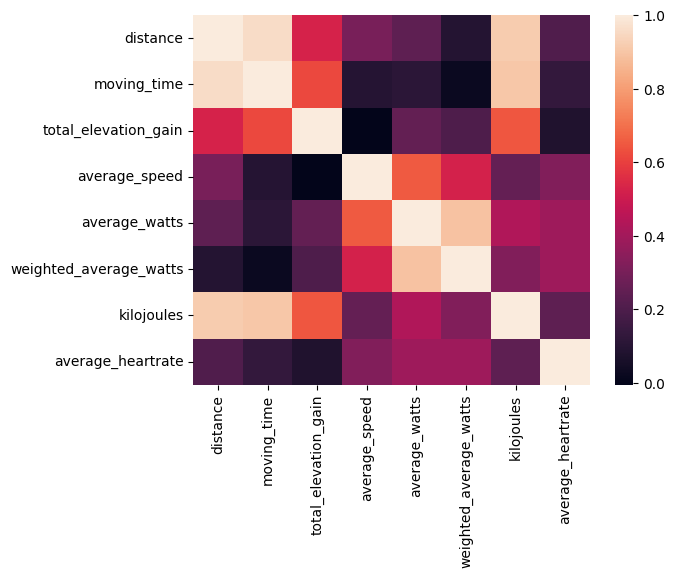

In [6]:
sns.heatmap(df.select_dtypes(include=np.number).corr());

- Distance and moving time are the most correlated to kilojoules. Total elevation gain follows with average wattage being the 4th most correlated.

- Moving time and distance are highly correlated
- Average watts and normalized watts are highly correlated 
- the only negative correlation is between average speed and total elevation gain

- all these relationships make sense are intuitive to what you would expect

Note: For a baseline model, I am going to keep all of these features.  

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
distance,1166.0,22.149657,13.331293,0.08,13.9150,20.18,28.0575,100.28
moving_time,1166.0,71.262196,41.529616,0.57,45.6775,61.06,90.1700,309.80
total_elevation_gain,1166.0,742.155103,726.808492,0.00,289.5300,534.78,1021.1600,5406.82
average_speed,1166.0,18.424666,4.014404,4.37,17.0050,19.22,20.6300,67.77
average_watts,1166.0,135.050515,40.845985,0.00,117.7250,136.95,157.2000,371.00
weighted_average_watts,1021.0,152.285015,37.149197,15.00,128.0000,149.00,178.0000,301.00
kilojoules,1166.0,588.794511,381.358740,0.00,355.8000,516.95,764.0500,2193.70
average_heartrate,776.0,134.388789,26.719951,0.20,121.8000,135.80,151.6500,193.50


In [8]:
df.isna().sum()

distance                    0
moving_time                 0
total_elevation_gain        0
sport_type                  0
average_speed               0
average_watts               0
weighted_average_watts    145
kilojoules                  0
average_heartrate         390
dtype: int64

Based off these two tables, we see that there is a lot of missing data from power and heartrate fields. 
    - Remove any rows with 0 power data
    - Impute rows with missing normalized power data
    - Impute missing heartrate data
In addition, looking at the max/min, we will need to address some outliers.
Looking at mean/median/std, most of the data seems normal, but we have to explore further. 

Lastly, from personal exploration/experience, there are some activties with very very bad power data due to a faulty power meter so we will have to address all of this before we create a pipeline to preprocess the data.

## Distributions and Transformations

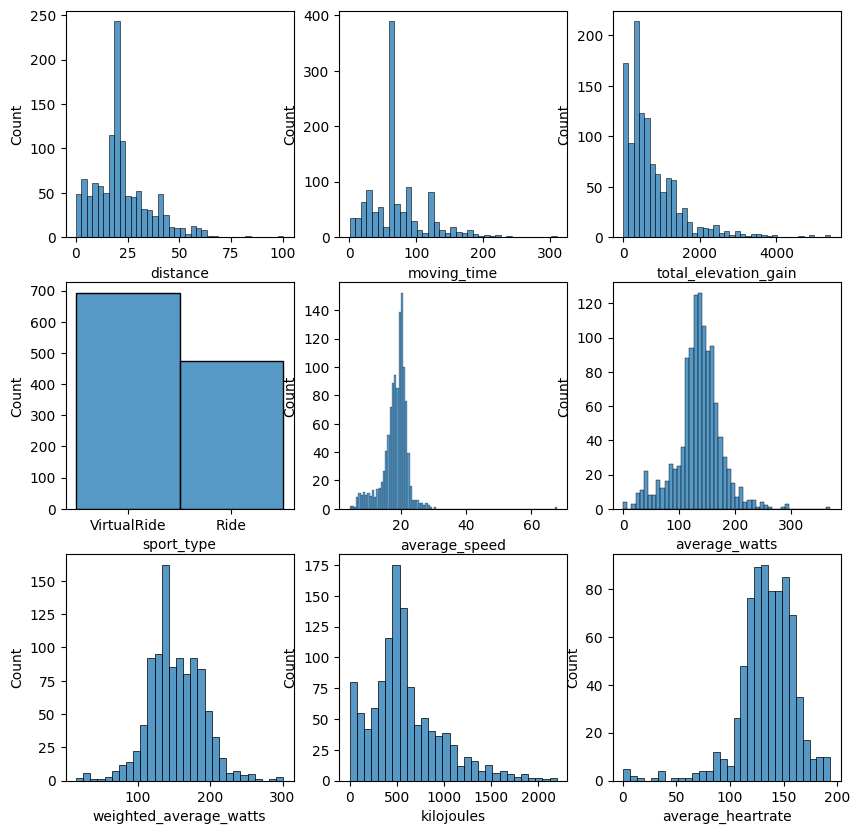

In [9]:
fig, ax = plt.subplots(3,3, figsize=(10,10))

flat_ax = ax.flatten()

for i, ax in enumerate(flat_ax):
    sns.histplot(data=df[df.columns[i]], ax=ax)
    
plt.show()

We see that many of the distributions are approximately normal. The two that may need some transformation are total elevation gain and kilojoules.

We will try a log transformation and square root transformation to attempt to fix these skews.

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


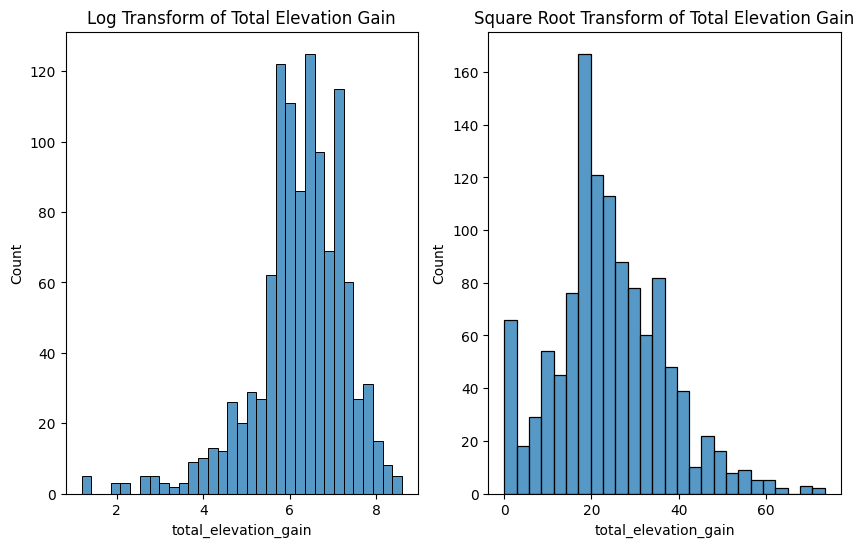

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))

sns.histplot(np.log(df['total_elevation_gain']), ax=ax[0])
ax[0].set_title('Log Transform of Total Elevation Gain')

sns.histplot(np.sqrt(df['total_elevation_gain']), ax=ax[1])
ax[1].set_title('Square Root Transform of Total Elevation Gain')

fig.show()

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


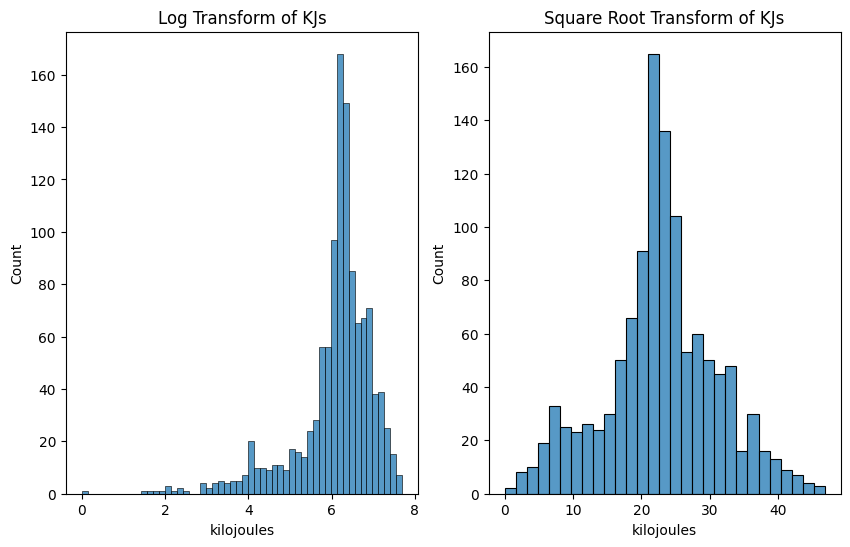

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))

sns.histplot(np.log(df['kilojoules']), ax=ax[0])
ax[0].set_title('Log Transform of KJs')

sns.histplot(np.sqrt(df['kilojoules']), ax=ax[1])
ax[1].set_title('Square Root Transform of KJs')

fig.show()

So far, it seems that square transforms of these two distirbutions yield the best results upon "eyeball" inspection. 

We can use a Q-Q plot or the Shapiro-Wilk test to quantitatively test out normality but we will forgo that for simplicity.

## Outliers and Dealing with Bad Data

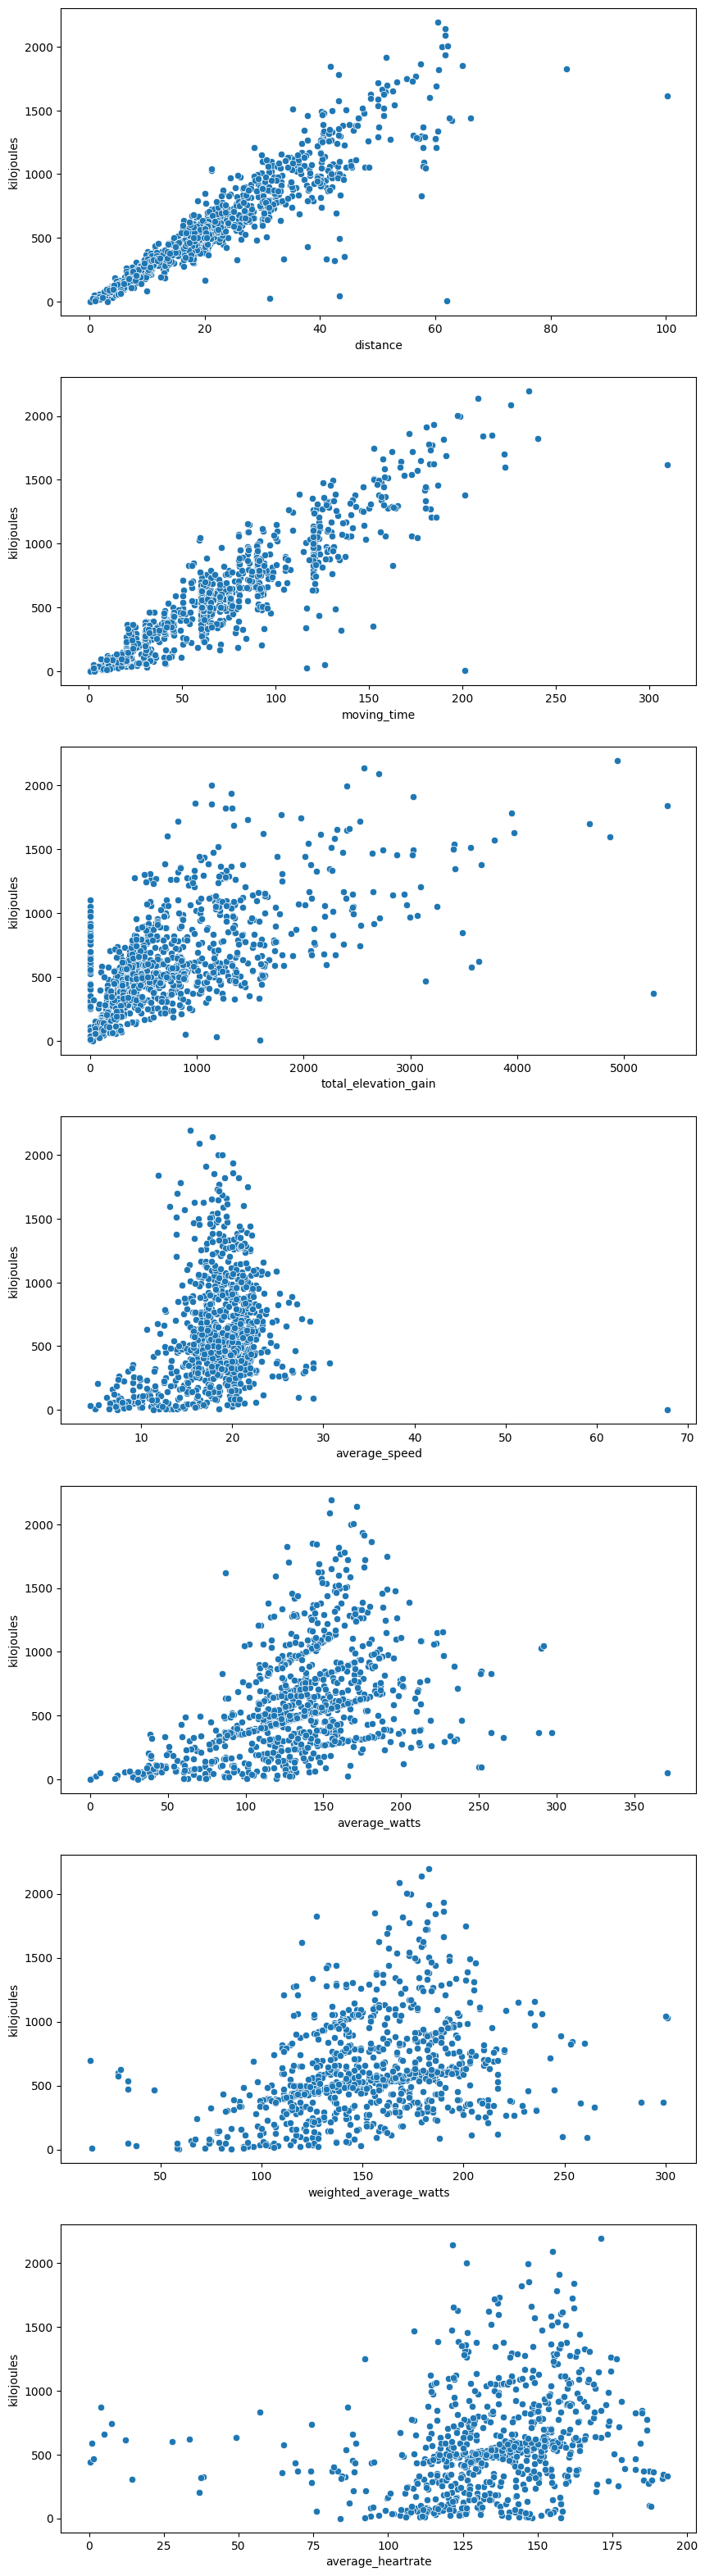

In [12]:
cols = ['distance', 'moving_time', 'total_elevation_gain', 'average_speed',
        'average_watts', 'weighted_average_watts', 'average_heartrate']
fig, ax = plt.subplots(7,1, figsize=(10,40))

flat_ax = ax.flatten()

for i, ax in enumerate(flat_ax):
    sns.scatterplot(x=df[cols[i]], y=df['kilojoules'], data=df, ax=ax)
    
plt.show()

Identify data that has KJ data that is too low for given distances, times, etc:

Outlier Data:
- distances greater than 20 where
    - avgerage watts is less than 80
    - sport type is outdoor rides
    - average speed is greater than 15

In [13]:
mask = (df['distance'] >= 20 ) & (df['average_watts'] <= 80) & (df['sport_type'] == 'Ride') & (df['average_speed'] >= 15)
df.loc[mask]

,distance,moving_time,total_elevation_gain,sport_type,average_speed,average_watts,weighted_average_watts,kilojoules,average_heartrate
701,44.15,152.08,1492.78,Ride,17.42,38.5,116.0,351.3,135.3
737,62.02,201.27,1593.18,Ride,18.49,0.5,16.0,6.5,140.2
746,31.33,116.82,1184.38,Ride,16.09,3.9,38.0,27.2,130.8
751,20.01,70.20,239.50,Ride,17.10,39.2,85.0,164.9,157.6
752,41.03,116.13,843.18,Ride,21.20,48.3,122.0,336.5,159.2
801,42.56,135.20,1351.71,Ride,18.89,39.8,75.0,322.6,135.3
824,43.39,126.28,895.67,Ride,20.62,6.4,34.0,48.7,137.7
839,33.73,93.95,629.92,Ride,21.54,59.3,115.0,334.5,119.2
877,37.76,123.18,679.13,Ride,18.39,58.5,81.0,432.7,131.2
953,43.37,116.78,767.72,Ride,22.28,70.6,161.0,494.7,136.1


In [14]:
# drop the bad data outliers
df = df.loc[~mask]

In [15]:
# fix century ride from broken powermeter

df.loc[df['moving_time'] > 300]


,distance,moving_time,total_elevation_gain,sport_type,average_speed,average_watts,weighted_average_watts,kilojoules,average_heartrate
825,100.28,309.8,2158.79,Ride,19.42,86.9,120.0,1616.1,158.4


In [16]:
df.loc[825, 'average_watts'] = 86.9*1.9
df.loc[825, 'weighted_average_watts'] = 86.9*1.9
df.loc[825, 'kilojoules'] = 1616.1 * 1.5

df.loc[825]

distance                   100.28
moving_time                 309.8
total_elevation_gain      2158.79
sport_type                   Ride
average_speed               19.42
average_watts              165.11
weighted_average_watts     165.11
kilojoules                2424.15
average_heartrate           158.4
Name: 825, dtype: object

In [17]:
# drop car ride data (any avg_speed over 30)
df = df.loc[df['average_speed'] < 30]

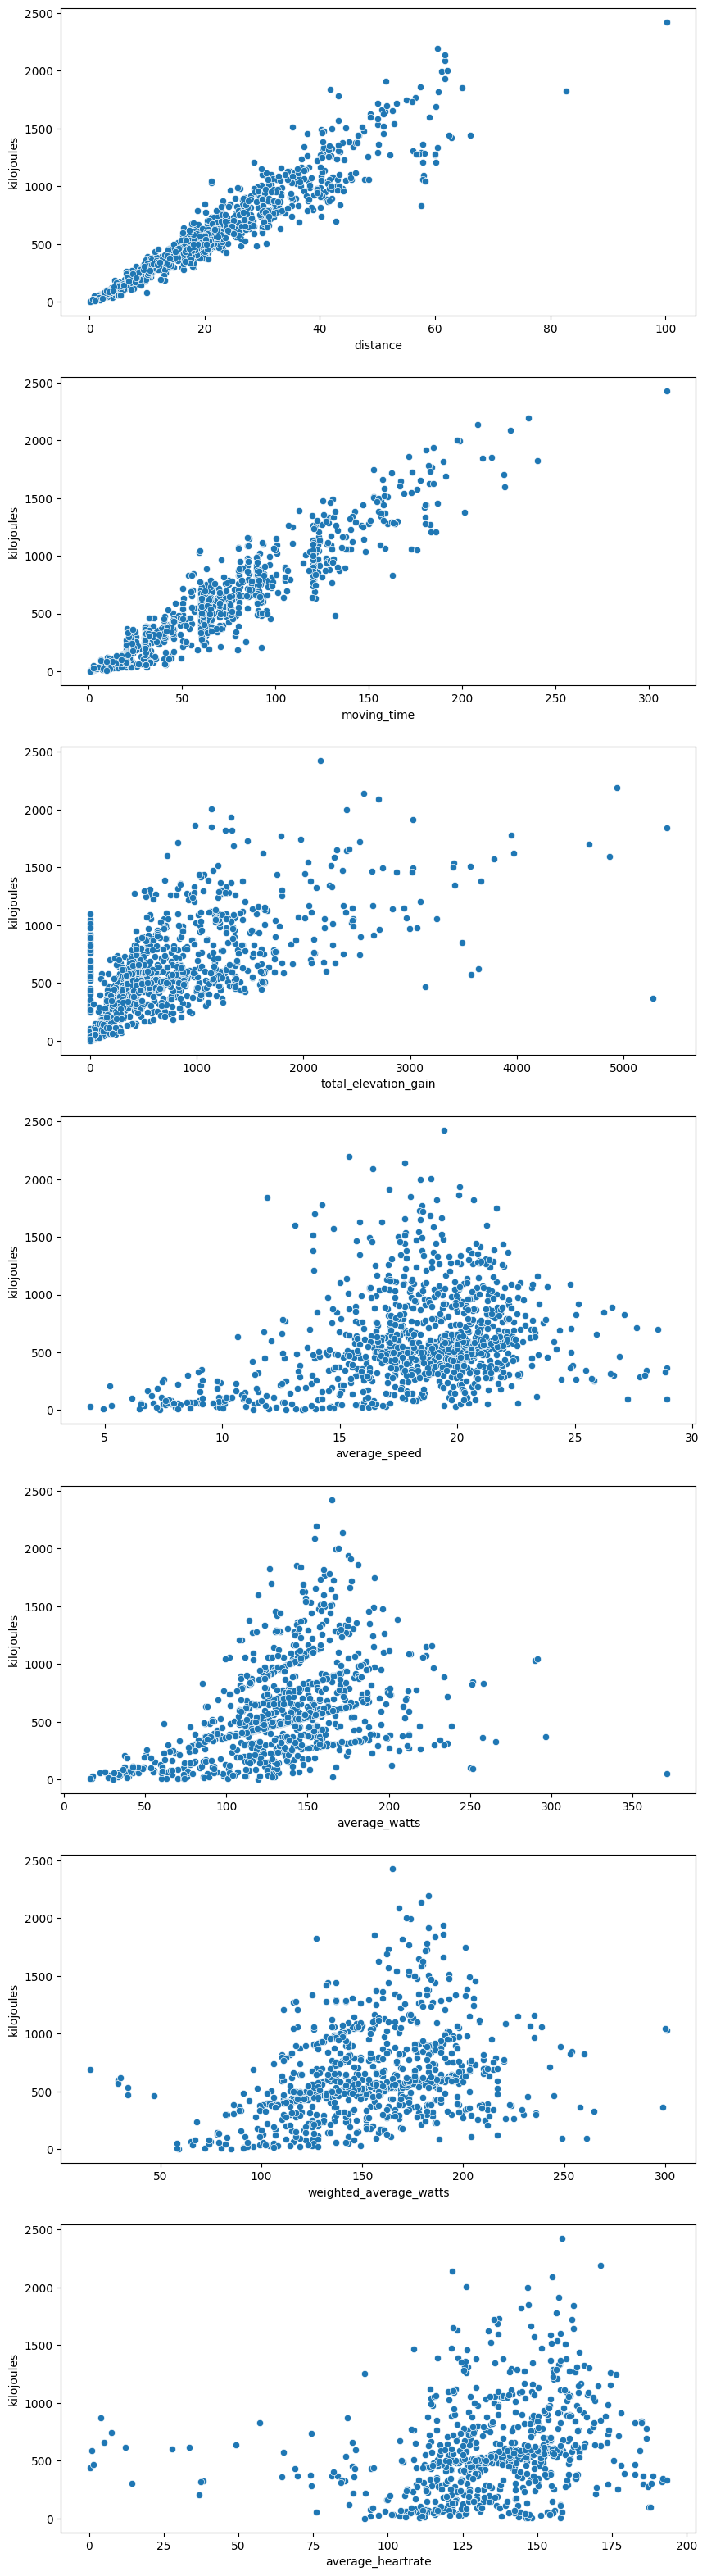

In [18]:
cols = ['distance', 'moving_time', 'total_elevation_gain', 'average_speed',
        'average_watts', 'weighted_average_watts', 'average_heartrate']
fig, ax = plt.subplots(7,1, figsize=(10,40))

flat_ax = ax.flatten()

for i, ax in enumerate(flat_ax):
    sns.scatterplot(x=df[cols[i]], y=df['kilojoules'], data=df, ax=ax)
    
plt.show()

Now that we have eliminated most of the outlier data, we can move on to building the pipeline. However, before we do that, after getting familiar with the data/exploring and looking at correlations, I will drop the average_heartrate feature. 

Lastly, I want to see how many missing values are left after the cleaning/filtering. We will impute these using multiple methods. 

## Missing Values

In [19]:
df.isna().sum()

distance                    0
moving_time                 0
total_elevation_gain        0
sport_type                  0
average_speed               0
average_watts               0
weighted_average_watts    144
kilojoules                  0
average_heartrate         390
dtype: int64

We have 145 missing values for weighted_average_watts which we can impute using LinearRegression with sklearn.

# Pipeline

In [20]:
def standard_clean(df):
    '''
    Standard cleaning:
        1. filter by SportType
        2. remove unnecessary columns
        3. drop activties with missing power data

    '''
    X = df.copy()
    
    # filter by sports type
    X = X.loc[(X['sport_type'] == 'VirtualRide') | (X['sport_type'] == 'Ride')].reset_index(drop=True)
    
    # drop unused columns
    X = X.drop(['name', 'achievement_count', 'pr_count', 
                'average_cadence', 'time', 'time_bins', 'elapsed_time', 'date', 'average_heartrate'], axis=1)
    # drop any rows with missing power data
    X = X.loc[~X['average_watts'].isna()].reset_index(drop=True)
    
    # drop outlier data based off this mask
    mask = (X['distance'] >= 20 ) & (X['average_watts'] <= 80) & (X['sport_type'] == 'Ride') & (X['average_speed'] >= 15)
    X = X.loc[~mask]
    
    return X

In [21]:
df = standard_clean(pd.read_csv(os.path.join(dirname, filename)))
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1155 entries, 0 to 1165
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   distance                1155 non-null   float64
 1   moving_time             1155 non-null   float64
 2   total_elevation_gain    1155 non-null   float64
 3   sport_type              1155 non-null   object 
 4   average_speed           1155 non-null   float64
 5   average_watts           1155 non-null   float64
 6   weighted_average_watts  1010 non-null   float64
 7   kilojoules              1155 non-null   float64
dtypes: float64(7), object(1)
memory usage: 81.2+ KB


In [22]:
# split data

X = df.loc[:, ~df.columns.isin(['kilojoules'])]
y = np.sqrt(df.loc[:, df.columns.isin(['kilojoules'])])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [23]:
# create the square root transform
sqrt_pipeline = Pipeline(
    steps=[
        ('impute_regression', IterativeImputer(estimator=LinearRegression())),
        ('sqrt_transform', FunctionTransformer(np.sqrt, feature_names_out='one-to-one')),
        ('strandard_scaler', StandardScaler())
    ]
)

numeric_pipeline = Pipeline(
    steps=[
        ('impute_regression', IterativeImputer(estimator=LinearRegression())),
        ('standard_scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    [
        ('nums', numeric_pipeline, ['distance', 'moving_time', 'average_speed', 'average_watts', 'weighted_average_watts']),
        ('sqrt_tranform', sqrt_pipeline, ['total_elevation_gain'])
    ], remainder='drop'
)

preprocessor

ColumnTransformer(transformers=[('nums',
                                 Pipeline(steps=[('impute_regression',
                                                  IterativeImputer(estimator=LinearRegression())),
                                                 ('standard_scaler',
                                                  StandardScaler())]),
                                 ['distance', 'moving_time', 'average_speed',
                                  'average_watts', 'weighted_average_watts']),
                                ('sqrt_tranform',
                                 Pipeline(steps=[('impute_regression',
                                                  IterativeImputer(estimator=LinearRegression())),
                                                 ('sqrt_transform',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'sqrt'>)),
                                                 ('strandard_scaler',
                                                  StandardScaler())]),
                                 ['total_elevation_gain'])])

# Model Exploration and Cross Validation
1. Linear Regression
2. Random Forest Regression
3. XGBoost Regression

In [24]:
linear_regression = Pipeline(
    steps = 
    [
        ('preprocess', preprocessor),
        ('linear_regression', LinearRegression())
    ]
)

linear_regression

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nums',
                                                  Pipeline(steps=[('impute_regression',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'moving_time',
                                                   'average_speed',
                                                   'average_watts',
                                                   'weighted_average_watts']),
                                                 ('sqrt_tranform',
                                                  Pipeline(steps=[('impute_regression',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('sqrt_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'sqrt'>)),
                                                                  ('strandard_scaler',
                                                                   StandardScaler())]),
                                                  ['total_elevation_gain'])])),
                ('linear_regression', LinearRegression())])

In [25]:
linear_mses = -cross_val_score(linear_regression, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
pd.Series(linear_mses).describe().T

count    10.000000
mean      1.850620
std       0.590545
min       1.287368
25%       1.563103
50%       1.646013
75%       1.801103
max       3.269739
dtype: float64

In [26]:
randomForest_regression = Pipeline(
    steps = 
    [
        ('preprocess', preprocessor),
        ('random_forest', RandomForestRegressor(random_state=24))
    ]
)
randomForest_regression

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nums',
                                                  Pipeline(steps=[('impute_regression',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'moving_time',
                                                   'average_speed',
                                                   'average_watts',
                                                   'weighted_average_watts']),
                                                 ('sqrt_tranform',
                                                  Pipeline(steps=[('impute_regression',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('sqrt_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'sqrt'>)),
                                                                  ('strandard_scaler',
                                                                   StandardScaler())]),
                                                  ['total_elevation_gain'])])),
                ('random_forest', RandomForestRegressor(random_state=24))])

In [27]:
randomForest_mses = -cross_val_score(randomForest_regression, X_train, y_train.to_numpy().reshape(-1), scoring='neg_root_mean_squared_error', cv=10)
pd.Series(randomForest_mses).describe().T

count    10.000000
mean      0.874101
std       0.146325
min       0.676344
25%       0.796528
50%       0.829137
75%       1.007181
max       1.100735
dtype: float64

In [28]:
xgBoost_regression = Pipeline(
    steps = 
    [
        ('preprocess', preprocessor),
        ('xgboost', xgb.XGBRegressor())
    ]
)

xgBoost_regression

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nums',
                                                  Pipeline(steps=[('impute_regression',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'moving_time',
                                                   'average_speed',
                                                   'average_watts',
                                                   'weighted_average_watts']),
                                                 ('sqrt_tranform',
                                                  Pipeline(steps=[('impute_regression',
                                                                   IterativeImputer(...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [29]:
xgboost_mses = -cross_val_score(xgBoost_regression, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
pd.Series(xgboost_mses).describe().T

count    10.000000
mean      0.726467
std       0.074335
min       0.642689
25%       0.662844
50%       0.728183
75%       0.767918
max       0.881900
dtype: float64

Based on the error and cross validation scores, XGBoost performed the best.

# Fine-tune XGBoost Model

In [30]:
param_grid = {
    'xgboost__n_estimators': [100, 300, 600, 1000],
    'xgboost__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'xgboost__max_depth': [3, 5, 7, 9]
}

grid_search = GridSearchCV(xgBoost_regression, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nums',
                                                                         Pipeline(steps=[('impute_regression',
                                                                                          IterativeImputer(estimator=LinearRegression())),
                                                                                         ('standard_scaler',
                                                                                          StandardScaler())]),
                                                                         ['distance',
                                                                          'moving_time',
                                                                          'average_speed',
                                                                          'average_watts',
                                                                          'weighted_average_watts']),
                                                                        ('sqrt_tranform',
                                                                         Pipeline(steps=[('impute_r...
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             param_grid={'xgboost__learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'xgboost__max_depth': [3, 5, 7, 9],
                         'xgboost__n_estimators': [100, 300, 600, 1000]},
             scoring='neg_root_mean_squared_error')

## Select Best Estimator and Evaluate on Test Set

In [31]:
# this is the best model
grid_search.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nums',
                                                  Pipeline(steps=[('impute_regression',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'moving_time',
                                                   'average_speed',
                                                   'average_watts',
                                                   'weighted_average_watts']),
                                                 ('sqrt_tranform',
                                                  Pipeline(steps=[('impute_regression',
                                                                   IterativeImputer(...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=1000,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [32]:
# this is the best params
grid_search.best_params_

{'xgboost__learning_rate': 0.1,
 'xgboost__max_depth': 3,
 'xgboost__n_estimators': 1000}

In [33]:
# evaluate on test data

final_mse = mean_squared_error(y_test**2, grid_search.predict(X_test)**2, squared=False)
final_mse

25.988814014063514

# Results

In [34]:
preprocessor.fit(X_train, y_train)
for col, score in zip(preprocessor.get_feature_names_out(), grid_search.best_estimator_.named_steps['xgboost'].feature_importances_):
    print(f'{col.upper()}: {score}')

NUMS__DISTANCE: 0.7597651481628418
NUMS__MOVING_TIME: 0.1589190810918808
NUMS__AVERAGE_SPEED: 0.0039516049437224865
NUMS__AVERAGE_WATTS: 0.03956582769751549
NUMS__WEIGHTED_AVERAGE_WATTS: 0.01593167707324028
SQRT_TRANFORM__TOTAL_ELEVATION_GAIN: 0.02186678722500801


In [35]:
final_mse

25.988814014063514

In [36]:
raw_results = pd.DataFrame(
    {
        'Predicted Value': pd.Series(grid_search.predict(X_test)**2),
        'True Value': (y_test.reset_index(drop=True)**2)['kilojoules']
    }
).assign(Difference=lambda x: x['Predicted Value'] - x['True Value'])
raw_results

,Predicted Value,True Value,Difference
0,467.231140,455.6,11.631140
1,779.723877,715.0,64.723877
2,597.285400,593.0,4.285400
3,468.389862,492.7,-24.310138
4,1014.205200,1032.3,-18.094800
...,...,...,...
226,615.311768,600.6,14.711768
227,48.383480,54.4,-6.016520
228,588.146667,590.3,-2.153333
229,879.618408,875.6,4.018408


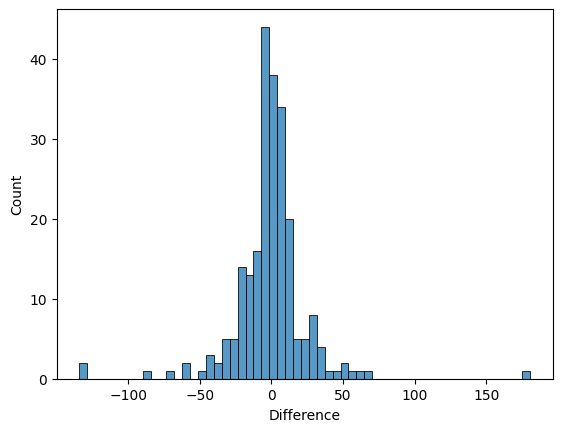

In [37]:
# distribution of Model Residuals (Actual-Predicted) --> Since roughly normal, I am fairly confident in the performance of my model
sns.histplot(x='Difference', data=raw_results);

In [38]:
# calculate the R-squared value for results
corr_matrix = np.corrcoef(raw_results['True Value'], raw_results['Predicted Value'])
corr = corr_matrix[0,1]
R_sq = corr**2

print(R_sq)

0.9945437059138811


Our final model has an MSE of about 26. On average, the ML model is only 26 kilojoules off from the actual values. 

The top 3 most important features were:
1. distance
2. moving time
3. average watts

The 3 least important features are:
1. average speed
2. weighted average watts
3. total elevation gain

# Save the model

In [39]:
import joblib

# this will include the preprocessing steps AND the final estimator
cycling_regression = grid_search.best_estimator_

joblib.dump(cycling_regression, 'cycling_regression.pkl')

['cycling_regression.pkl']

# Limitations:
- The data is based off my cycing data and therefore, the patterns learned by the model are influenced by my physiology
    - this will not generalize to the general public as I need way more training data
- Training data was limited to about 1k activities which is not many
- My training data is biased to 1 hr rides

Future Improvements:
- Get more training data
- Test on data from other people
- Can we instead see the results when training on outside rides vs inside rides?
- What other features can we incorporate, remove, or engineer to improve our results?